# Introduction

An EDA of Israel's bus fleet.

### Initialising

In [1]:
# general
import pandas as pd
import numpy as np
import math
from datetime import datetime
from scipy import stats as st
import joblib as jbl

# Clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler

# Graphing
import matplotlib.pyplot as plt
from plotly import express as px, graph_objects as go
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('Paired')

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore") 

##### Loading Dataset
The bus_vehicles table is a dataset of government collected data containing all registered buses that are still on the road, as well as other characteristics such as their operating companies.

In [2]:
bus_vehicles = pd.read_csv('Downloads/bus_fleet.csv', sep='|')
# source: https://data.gov.il/dataset/bus_fleet



Date when the data was downloaded, which for our analysis will be the current date:

In [3]:
current = datetime.strptime('25-11-2022', '%d-%m-%Y')
current

datetime.datetime(2022, 11, 25, 0, 0)

##### A Look at the Dataset


In [4]:
bus_vehicles.info()
# the only column we see nulls in is the total_kilometer column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12716 entries, 0 to 12715
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   operator_nm         12716 non-null  object 
 1   bus_license_id      12716 non-null  int64  
 2   stone_proof_nm      12716 non-null  object 
 3   bullet_proof_nm     12716 non-null  object 
 4   BusSize_nm          12716 non-null  object 
 5   BusType_nm          12716 non-null  object 
 6   SeatsNum            12716 non-null  int64  
 7   production_year     12716 non-null  int64  
 8   production_country  12716 non-null  object 
 9   total_kilometer     12707 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 993.6+ KB


In [5]:
bus_vehicles.describe()
# production years range from 2003 to 2022, distance passed ranges from 0 to 9.5 in millions
# there are busses with zero seats apparently, suspicious.

bus_license_id      SeatsNum  production_year  total_kilometer
count    1.271600e+04  12716.000000     12716.000000     1.270700e+04
mean     2.323953e+07     40.971375      2017.389509     3.055488e+05
std      2.474355e+07      9.536080         3.351451     2.863435e+05
min      1.009634e+06      0.000000      2003.000000     0.000000e+00
25%      7.583844e+06     36.000000      2015.000000     8.610950e+04
50%      9.216951e+06     38.000000      2018.000000     2.668060e+05
75%      3.162043e+07     51.000000      2021.000000     4.634395e+05
max      9.275690e+07     73.000000      2022.000000     9.444510e+06

In [6]:
bus_vehicles.head()
# plenty of object columns might actually be boolean

operator_nm  bus_license_id  stone_proof_nm bullet_proof_nm BusSize_nm  \
0  אגד תעבורה         1845613  לא ממוגן אבנים    לא ממוגן ירי    אוטובוס   
1  אגד תעבורה         3428589  לא ממוגן אבנים       ממוגן ירי    אוטובוס   
2  אגד תעבורה         3428689  לא ממוגן אבנים       ממוגן ירי    אוטובוס   
3  אגד תעבורה         3428789  לא ממוגן אבנים       ממוגן ירי    אוטובוס   
4  אגד תעבורה         3428889  לא ממוגן אבנים       ממוגן ירי    אוטובוס   

  BusType_nm  SeatsNum  production_year production_country  total_kilometer  
0  בינעירוני        51             2010              הולנד         948993.0  
1  בינעירוני        51             2017               ספרד         428194.0  
2  בינעירוני        51             2017               ספרד         352619.0  
3  בינעירוני        51             2017               ספרד         380961.0  
4  בינעירוני        51             2017               ספרד         431851.0

Looking for duplicates:

In [7]:
bus_vehicles.bus_license_id.duplicated().sum()

2

In [8]:
bus_vehicles[bus_vehicles.bus_license_id.duplicated()]

operator_nm  bus_license_id  stone_proof_nm bullet_proof_nm BusSize_nm  \
10927       קווים         7271452  לא ממוגן אבנים    לא ממוגן ירי    אוטובוס   
10931       קווים         7271852  לא ממוגן אבנים    לא ממוגן ירי    אוטובוס   

      BusType_nm  SeatsNum  production_year production_country  \
10927     עירוני        36             2014              שבדיה   
10931     עירוני        36             2014              שבדיה   

       total_kilometer  
10927         395994.0  
10931         434567.0

In [9]:
duplicated_license = [7271452, 7271852]
bus_vehicles[bus_vehicles.bus_license_id.isin(duplicated_license)]
# kavim and electra afikim share two lines apparently
# but which is the true owner?

operator_nm  bus_license_id  stone_proof_nm bullet_proof_nm  \
3824   אלקטרה אפיקים         7271452  לא ממוגן אבנים    לא ממוגן ירי   
3825   אלקטרה אפיקים         7271852  לא ממוגן אבנים    לא ממוגן ירי   
10927          קווים         7271452  לא ממוגן אבנים    לא ממוגן ירי   
10931          קווים         7271852  לא ממוגן אבנים    לא ממוגן ירי   

      BusSize_nm BusType_nm  SeatsNum  production_year production_country  \
3824     אוטובוס     עירוני        36             2014              שבדיה   
3825     אוטובוס     עירוני        36             2014              שבדיה   
10927    אוטובוס     עירוני        36             2014              שבדיה   
10931    אוטובוס     עירוני        36             2014              שבדיה   

       total_kilometer  
3824          395994.0  
3825          434567.0  
10927         395994.0  
10931         434567.0

I don't see any way to determine which operator truly owns these duplicated buses, so when cleaning the data I will remove these null rows.

Looking at the slice of the data where the total distance is null.

In [10]:
bus_vehicles[bus_vehicles.total_kilometer.isna()]

operator_nm  bus_license_id  stone_proof_nm bullet_proof_nm  \
380       אגד תעבורה         8790201  לא ממוגן אבנים    לא ממוגן ירי   
413       אגד תעבורה         8798501  לא ממוגן אבנים    לא ממוגן ירי   
3330             אגד        23334202  לא ממוגן אבנים    לא ממוגן ירי   
3331             אגד        23334302  לא ממוגן אבנים    לא ממוגן ירי   
3332             אגד        23334402  לא ממוגן אבנים    לא ממוגן ירי   
3333             אגד        23334502  לא ממוגן אבנים    לא ממוגן ירי   
3591   אלקטרה אפיקים         1009734     ממוגן אבנים    לא ממוגן ירי   
3608   אלקטרה אפיקים         1249734     ממוגן אבנים    לא ממוגן ירי   
10576          קווים         1828811  לא ממוגן אבנים    לא ממוגן ירי   

      BusSize_nm BusType_nm  SeatsNum  production_year production_country  \
380      אוטובוס     עירוני         0             2008              הולנד   
413      אוטובוס     עירוני        40             2009              הולנד   
3330     אוטובוס  בינעירוני        73             2021              פולין   
3331     אוטובוס  בינעירוני        73             2021              פולין   
3332     אוטובוס  בינעירוני        73             2021              פולין   
3333     אוטובוס  בינעירוני        73             2021              פולין   
3591     מיניבוס  בינעירוני        19             2015             גרמניה   
3608     מיניבוס  בינעירוני        19             2016             גרמניה   
10576    מיניבוס  בינעירוני         2             2013             גרמניה   

       total_kilometer  
380                NaN  
413                NaN  
3330               NaN  
3331               NaN  
3332               NaN  
3333               NaN  
3591               NaN  
3608               NaN  
10576              NaN

In [11]:
bus_vehicles[bus_vehicles.total_kilometer == 0]['total_kilometer'].count()

580

Nothing stands out in particular, but there aren't a lot of rows of this kind in comparison to the size of our data, so I intend to play it safe and remove these as well.

How many zero-seat busses do we have?

In [12]:
bus_vehicles[bus_vehicles.SeatsNum<1]['SeatsNum'].count()

1

##### Viewing column values to decide how to encode them

In [13]:
print(
bus_vehicles.stone_proof_nm.value_counts(), '\n', # convert to yes/no
bus_vehicles.bullet_proof_nm.value_counts(), '\n', # convert to yes/no
bus_vehicles.BusType_nm.value_counts() # convert to yes/no inter-city
) 

לא ממוגן אבנים    12331
ממוגן אבנים         385
Name: stone_proof_nm, dtype: int64 
 לא ממוגן ירי    12558
ממוגן ירי         158
Name: bullet_proof_nm, dtype: int64 
 עירוני       7655
בינעירוני    5061
Name: BusType_nm, dtype: int64


I've decided to convert these three columns to boolean features.

Looking into the operator names:

In [14]:
bus_vehicles.operator_nm.value_counts() # ירושלים - עיסאוויה מחנה שעפאט vs ירושלים-שועפאט who'd win
# there are loads of operators and it's unclear which are duplicated and which aren't
# considering making this category though

אגד                               3049
קווים                             1540
דן                                1329
מטרופולין                         1240
סופרבוס                            996
אלקטרה אפיקים                      828
אגד תעבורה                         542
נתיב אקספרס                        541
תנופה                              441
דן בדרום                           426
נסיעות ותיירות                     252
דן באר שבע                         241
בית שמש אקספרס                     236
ש.א.מ                              186
אקסטרה                             186
גלים                               153
ירושלים-רמאללה איחוד                99
אקסטרה ירושלים                      92
גי.בי.טורס                          78
מועצה אזורית גולן                   56
ירושלים-אלווסט איחוד                44
ירושלים-דרום איחוד                  43
ירושלים-אבו-תור-ענאתא איחוד         35
ירושלים-הר הזיתים                   25
מועצה אזורית אילות                  21
ירושלים - עיסאוויה מחנה ש

I've decided to translate these values and look for parent companies and sister companies in this data. I've also decided, after looking for each operator name online and only finding one bus company with Shoafat in its name, that the Jerusalem-Shoafat company that only has one bus is the result of an error.

Looking into bus sizes:

In [15]:
bus_vehicles.BusSize_nm.value_counts() # maybe look up the sizes of buses? maybe just category


אוטובוס          11046
מפרקי 4 דלתות      722
מיניבוס            679
מידיבוס            220
מפרקי 5 דלתות       29
מפרקי 3 דלתות       20
Name: BusSize_nm, dtype: int64

I've decided to encode bus sizes as the length of a bus in meters.

Looking into production countries:

In [16]:
bus_vehicles.production_country.value_counts() # two spellings of Turkey
# will probably convert this data to category

סין        4148
שבדיה      2821
גרמניה     2756
פולין       989
ספרד        951
תורקיה      509
הולנד       407
טורקיה       95
איטליה       38
לא ידוע       1
ישראל         1
Name: production_country, dtype: int64

I've decided I'll translate this field and convert it to category datatype, but first I want to look at the suspicious values:

In [17]:
bus_vehicles[bus_vehicles['production_country']=='לא ידוע'] # a bus mysteriously appeared

operator_nm  bus_license_id  stone_proof_nm bullet_proof_nm BusSize_nm  \
6876          דן         9475274  לא ממוגן אבנים    לא ממוגן ירי    אוטובוס   

     BusType_nm  SeatsNum  production_year production_country  total_kilometer  
6876     עירוני        31             2013            לא ידוע         106482.0

In [18]:
bus_vehicles[bus_vehicles['production_country']=='ישראל'] 
# there is only 1 israel-made bus in israel's public transport system

operator_nm  bus_license_id  stone_proof_nm  \
7202  ירושלים-אבו-תור-ענאתא איחוד        31615101  לא ממוגן אבנים   

     bullet_proof_nm BusSize_nm BusType_nm  SeatsNum  production_year  \
7202    לא ממוגן ירי    מידיבוס     עירוני        24             2018   

     production_country  total_kilometer  
7202              ישראל          79177.0

##### Data Cleaning

I intend to:
- Rename columns.
- Correct misspellings:
    - Misspelled operators.
    - Misspelled production countries.
- Convert to boolean:
    - Column stone_proof_nm.
    - Column bullet_proof_nm.
    - Column BusType_nm. 
- Translate and convert to category datatype:
    - Column production_country. 
    - Column BusSize_nm.
- Find parent companies and convert to category datatype: 
    - Column operator_nm.
- Treat missing values:
    - Production countries.
    - Kilometers.
    - Seatcounts.

A seperate table to perform the changes on:

In [20]:
bus = bus_vehicles.copy()

In [21]:
bus.columns

Index(['operator_nm', 'bus_license_id', 'stone_proof_nm', 'bullet_proof_nm',
       'BusSize_nm', 'BusType_nm', 'SeatsNum', 'production_year',
       'production_country', 'total_kilometer'],
      dtype='object')

New column names to set:

In [22]:
bus.columns = ['operator', 'bus_license_id', 'is_stone_proof', 'is_bullet_proof',
       'bus_size', 'is_inter_city', 'seats_num', 'production_year',
       'production_country', 'total_kilometer']

Conversion to boolean:

In [23]:

is_stone_proof = {
    'לא ממוגן אבנים': False,
    'ממוגן אבנים': True
}
is_bullet_proof = {
    'לא ממוגן ירי': False,
    'ממוגן ירי': True
}
is_inter_city = {
    'בינעירוני': True,
    'עירוני': False
}

#is_stone_proof, is_bullet_proof, is_inter_city
bus.is_stone_proof = bus.is_stone_proof.map(is_stone_proof)
bus.is_bullet_proof = bus.is_bullet_proof.map(is_bullet_proof)
bus.is_inter_city = bus.is_inter_city.map(is_inter_city)
bus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12716 entries, 0 to 12715
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   operator            12716 non-null  object 
 1   bus_license_id      12716 non-null  int64  
 2   is_stone_proof      12716 non-null  bool   
 3   is_bullet_proof     12716 non-null  bool   
 4   bus_size            12716 non-null  object 
 5   is_inter_city       12716 non-null  bool   
 6   seats_num           12716 non-null  int64  
 7   production_year     12716 non-null  int64  
 8   production_country  12716 non-null  object 
 9   total_kilometer     12707 non-null  float64
dtypes: bool(3), float64(1), int64(3), object(3)
memory usage: 732.8+ KB


Successfully changed.

In [24]:
display(bus.loc[[7442,7165],:])

operator  bus_license_id  is_stone_proof  \
7442                  ירושלים-שועפאט         5938762           False   
7165  ירושלים - עיסאוויה מחנה שעפאט          3319032           False   

      is_bullet_proof bus_size  is_inter_city  seats_num  production_year  \
7442            False  מידיבוס           True         33             2009   
7165            False  אוטובוס          False         25             2015   

     production_country  total_kilometer  
7442             טורקיה         164676.0  
7165             תורקיה         153657.0

In [25]:
bus[bus['operator']=='ירושלים-שועפאט']

operator  bus_license_id  is_stone_proof  is_bullet_proof  \
7442  ירושלים-שועפאט         5938762           False            False   

     bus_size  is_inter_city  seats_num  production_year production_country  \
7442  מידיבוס           True         33             2009             טורקיה   

      total_kilometer  
7442         164676.0

In [26]:
bus[bus['operator']=='ירושלים - עיסאוויה מחנה שעפאט ']

operator  bus_license_id  is_stone_proof  \
7165  ירושלים - עיסאוויה מחנה שעפאט          3319032           False   
7166  ירושלים - עיסאוויה מחנה שעפאט          7266852           False   
7167  ירושלים - עיסאוויה מחנה שעפאט          7266952           False   
7168  ירושלים - עיסאוויה מחנה שעפאט          7267052           False   
7169  ירושלים - עיסאוויה מחנה שעפאט          7267152           False   
7170  ירושלים - עיסאוויה מחנה שעפאט          7466334           False   
7171  ירושלים - עיסאוויה מחנה שעפאט          7466434           False   
7172  ירושלים - עיסאוויה מחנה שעפאט          7466534           False   
7173  ירושלים - עיסאוויה מחנה שעפאט          7466734           False   
7174  ירושלים - עיסאוויה מחנה שעפאט          7467034           False   
7175  ירושלים - עיסאוויה מחנה שעפאט          8903384           False   
7176  ירושלים - עיסאוויה מחנה שעפאט          9052758           False   
7177  ירושלים - עיסאוויה מחנה שעפאט          9056658           False   
7178  ירושלים - עיסאוויה מחנה שעפאט         36823001           False   
7179  ירושלים - עיסאוויה מחנה שעפאט         65188201           False   
7180  ירושלים - עיסאוויה מחנה שעפאט         65188301           False   
7181  ירושלים - עיסאוויה מחנה שעפאט         79971702           False   
7182  ירושלים - עיסאוויה מחנה שעפאט         79971802           False   
7183  ירושלים - עיסאוויה מחנה שעפאט         79971902            True   

      is_bullet_proof bus_size  is_inter_city  seats_num  production_year  \
7165            False  אוטובוס          False         25             2015   
7166            False  אוטובוס          False         34             2015   
7167            False  אוטובוס          False         34             2015   
7168            False  אוטובוס          False         34             2015   
7169            False  אוטובוס          False         34             2015   
7170            False  מידיבוס          False         25             2016   
7171            False  מידיבוס          False         25             2016   
7172            False  מידיבוס          False         25             2016   
7173            False  אוטובוס          False         25             2016   
7174            False  מידיבוס          False         25             2016   
7175            False  מידיבוס          False         24             2017   
7176            False  מידיבוס          False         25             2017   
7177            False  אוטובוס          False         25             2017   
7178            False  אוטובוס          False         36             2018   
7179            False  מידיבוס          False         24             2019   
7180            False  מידיבוס          False         24             2019   
7181            False  אוטובוס          False         35             2022   
7182            False  אוטובוס          False         35             2022   
7183            False  אוטובוס          False         35             2022   

     production_country  total_kilometer  
7165             תורקיה         153657.0  
7166              שבדיה         263911.0  
7167              שבדיה         307536.0  
7168              שבדיה         238552.0  
7169              שבדיה         287562.0  
7170             תורקיה         211885.0  
7171             תורקיה         178959.0  
7172             תורקיה         193993.0  
7173             תורקיה         206872.0  
7174             תורקיה         116163.0  
7175             תורקיה         125613.0  
7176             תורקיה         143875.0  
7177             תורקיה         181575.0  
7178             תורקיה          74135.0  
7179             תורקיה         118664.0  
7180             תורקיה          86000.0  
7181             תורקיה            968.0  
7182             תורקיה            993.0  
7183             תורקיה            960.0

There is one bus run by an operator named "Jerusalem-Shoafat", while the operator "Jerusalem - Eisaweiah Shoafat Camp" operates 19 busses. I reached the conclusion (with the help of googling company names) that the operator that owns one bus only is actually a misspelling of another company.

Correcting the error:

In [27]:

bus.loc[bus['operator']=='ירושלים-שועפאט', 'operator'] = (
    bus[bus['operator']=='ירושלים - עיסאוויה מחנה שעפאט ']['operator'].head(1).values
)

In [28]:
bus.operator.value_counts()

אגד                               3049
קווים                             1540
דן                                1329
מטרופולין                         1240
סופרבוס                            996
אלקטרה אפיקים                      828
אגד תעבורה                         542
נתיב אקספרס                        541
תנופה                              441
דן בדרום                           426
נסיעות ותיירות                     252
דן באר שבע                         241
בית שמש אקספרס                     236
ש.א.מ                              186
אקסטרה                             186
גלים                               153
ירושלים-רמאללה איחוד                99
אקסטרה ירושלים                      92
גי.בי.טורס                          78
מועצה אזורית גולן                   56
ירושלים-אלווסט איחוד                44
ירושלים-דרום איחוד                  43
ירושלים-אבו-תור-ענאתא איחוד         35
ירושלים-הר הזיתים                   25
מועצה אזורית אילות                  21
ירושלים - עיסאוויה מחנה ש

The change was successful.

Translating country names:

In [29]:
translated_countries = {
    'הולנד': 'netherlands',
    'ספרד': 'spain',
    'סין': 'china',
    'שבדיה': 'switzerland',
    'תורקיה': 'turkey',
    'גרמניה': 'germany',
    'פולין': 'poland',
    'איטליה': 'italy',
    'טורקיה': 'turkey',
    'לא ידוע': 'unknown', #to be filled/removed later
    'ישראל': 'israel'
}
print('Before change:',bus.production_country.value_counts())
bus.production_country = bus.production_country.map(translated_countries)
print('After change:',bus.production_country.value_counts())

Before change: סין        4148
שבדיה      2821
גרמניה     2756
פולין       989
ספרד        951
תורקיה      509
הולנד       407
טורקיה       95
איטליה       38
לא ידוע       1
ישראל         1
Name: production_country, dtype: int64
After change: china          4148
switzerland    2821
germany        2756
poland          989
spain           951
turkey          604
netherlands     407
italy            38
unknown           1
israel            1
Name: production_country, dtype: int64


The change was successful.

I will be encoding bus sizes as their type's approximate length.

Summary:
- A minibus is 7.3
- A midibus is 8.75
- A regular bus is 12 to 15 meters
- An articulated bus is
    - 18.25 for the 3 door type
    - 18.75 for the 5 door type
    - Either 18.75 or 18.25 for the 4 door type
    
Reasoning:

I've read legal info as well the websites of companies that sell buses. They all differ on the precise sizes of specific busses, especially since the precise sizes really depend on the specific model you buy and not just the type of vehicle. But my goal in encoding this field is to communicate that busses of different builds are different in their size, and to communicate more or less how different they really are, and which are more similar to which. An approximation will be effective for that.

The closest I can do is set the mean value from differing sources. This decision applies to four-door busses most of all, since they are either the same length as a three-door bus or the same length as a five-door bus, depending on the production company, so I'm encoding them as the mean between three-door and five-door models, since there is no data on which bus is which model, and again, the point is to be able to differentiate buses in a meaningful way.


Sources:

- <a href="https://www.gov.il/BlobFolder/legalinfo/dimensions_and_weight_for_vehicles/he/313_A_3_midot_rechev.pdf">Legal data</a>
- <a href="http://www.merkavim.co.il/he/Project/2/%D7%9E%D7%90%D7%A8%D7%A1">Merkavim company</a>
- <a href="https://www.shlomo.co.il/byd/bus3.php">BYD</a>
- <a href="https://www.colmobil-commercials.co.il/commercials/mercedes-sprinter-19/">Colmobil</a>
- <a href="http://he.haargaz-transportation.com/html5/ProLookup.taf?_ID=27661&did=1140&G=9246&SM=">Ha'argaz</a>

In [30]:
bus_length = {
    'אוטובוס': 14,
    'מיניבוס': 7.3,
    'מפרקי 3 דלתות': 18.25,
    'מפרקי 4 דלתות' : 18.5,
    'מידיבוס' : 8.75,
    'מפרקי 5 דלתות' : 18.75
}
print('Before change:',bus.bus_size.value_counts())
bus.bus_size = bus.bus_size.map(bus_length)
print('After change:', bus.bus_size.value_counts())

Before change: אוטובוס          11046
מפרקי 4 דלתות      722
מיניבוס            679
מידיבוס            220
מפרקי 5 דלתות       29
מפרקי 3 דלתות       20
Name: bus_size, dtype: int64
After change: 14.00    11046
18.50      722
7.30       679
8.75       220
18.75       29
18.25       20
Name: bus_size, dtype: int64


The change was successful.

Translating the operator column:

In [31]:
company_names = {
    'אגד תעבורה': 'eged transport',
    'אגד': 'eged',
    'אלקטרה אפיקים': 'electra afikim',
    'אקסטרה ירושלים': 'extra jerusalem',
    'אקסטרה': 'extra',
    'בית שמש אקספרס': 'beit shemesh express',
    'גי.בי.טורס': 'g b tours',
    'גלים': 'galim',
    'דן באר שבע': 'dan beer sheva',
    'דן בדרום': 'dan south',
    'דן צפון': 'dan north',
    'דן': 'dan',
    'ירושלים - עיסאוויה מחנה שעפאט ': 'jerusalem shoafat',
    'ירושלים-אבו-תור-ענאתא איחוד': 'jerualem abu tour anta',
    'ירושלים-אלווסט איחוד': 'jerusalem alwest',
    'ירושלים-דרום איחוד': 'jerusalem south',
    'ירושלים-הר הזיתים': 'jerusalem har hazeitim',
    'ירושלים-צור באהר איחוד': 'jerusalem tzour baher',
    'ירושלים-רמאללה איחוד': 'jerusalem ramalah',
    'ירושלים-שועפאט': 'jerusalem shoafat',
    'מועצה אזורית אילות': 'eilot council',
    'מועצה אזורית גולן': 'golan council',
    'מטרופולין': 'metropolin',
    'נסיעות ותיירות': 'travel and tourism',
    'נתיב אקספרס': 'nativ express',
    'סופרבוס': 'superbus',
    'קווים': 'kavim',
    'ש.א.מ': 's a m',
    'תנופה': 'tnufa'
}
print('Before change:', bus.operator.value_counts())
bus.operator = bus.operator.map(company_names)
print('After change:', bus.operator.value_counts())

Before change: אגד                               3049
קווים                             1540
דן                                1329
מטרופולין                         1240
סופרבוס                            996
אלקטרה אפיקים                      828
אגד תעבורה                         542
נתיב אקספרס                        541
תנופה                              441
דן בדרום                           426
נסיעות ותיירות                     252
דן באר שבע                         241
בית שמש אקספרס                     236
ש.א.מ                              186
אקסטרה                             186
גלים                               153
ירושלים-רמאללה איחוד                99
אקסטרה ירושלים                      92
גי.בי.טורס                          78
מועצה אזורית גולן                   56
ירושלים-אלווסט איחוד                44
ירושלים-דרום איחוד                  43
ירושלים-אבו-תור-ענאתא איחוד         35
ירושלים-הר הזיתים                   25
מועצה אזורית אילות                  21
ירושלים - 

Many of the seperate operator names in the data are in fact each-other's daughter companies and sister companies. In order to have a more accurate image of the market when analysing it later on, I've researched which companies on this list are owned by the same group.

Sources: 
- <a href='https://en.checkid.co.il/'>CheckID</a>
- <a href='https://www.wikipedia.org/'>Wikipedia</a>
- and the sites of both local-councils listed:
    - <a href = 'https://www.calcalit-golan.co.il/golan-bus/'>Golan</a>
    - <a href = 'https://www.eilot.org.il/bus/'>Eilot</a>

In [32]:
parent_companies = {
    'eged transport': 'eged',
    'eged': 'eged',
    'electra afikim': 'electra',
    'extra jerusalem': 'extra',
    'extra': 'extra',
    'beit shemesh express': 'afifi family',
    'g b tours': 'g b tours',
    'galim': 'galim', #in part owned by the Blilios group, which owns Superbus
    'dan beer sheva': 'dan',
    'dan south': 'dan',
    'dan north': 'dan',
    'dan': 'dan',
    'jerusalem shoafat': 'united travel company',
    'jerualem abu tour anta': 'united travel company',
    'jerusalem alwest': 'united travel company',
    'jerusalem south': 'united travel company',
    'jerusalem har hazeitim': 'united travel company',
    'jerusalem tzour baher': 'united travel company',
    'jerusalem ramalah': 'united travel company',
    'eilot council': 'eilot council',
    'golan council': 'golan council',
    'metropolin': 'metropolin',
    'travel and tourism': 'afifi family',
    'nativ express': 'afifi family',
    'superbus': 'superbus',
    'kavim': 'kavim',
    's a m': 'afifi family',
    'tnufa': 'tnufa'
}
bus['parent_company'] = bus.operator.map(parent_companies)

bus.parent_company.value_counts()

eged                     3591
dan                      2001
kavim                    1540
metropolin               1240
afifi family             1215
superbus                  996
electra                   828
tnufa                     441
extra                     278
united travel company     278
galim                     153
g b tours                  78
golan council              56
eilot council              21
Name: parent_company, dtype: int64

Galim is partially owned by the Blilios group, which owns Superbus, but since they don't entirely own Galim, it wouldn't be precise to put all of Galim's busses under the Blilios name. There were more financial entities that owned significant portions of multiple companies, but I restricted this feature to complete ownerships, because there isn't any way that's true to reality to attribute a specific 30% of an operator's busses to a company that owns 30% of the operator.

In [33]:
bus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12716 entries, 0 to 12715
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   operator            12716 non-null  object 
 1   bus_license_id      12716 non-null  int64  
 2   is_stone_proof      12716 non-null  bool   
 3   is_bullet_proof     12716 non-null  bool   
 4   bus_size            12716 non-null  float64
 5   is_inter_city       12716 non-null  bool   
 6   seats_num           12716 non-null  int64  
 7   production_year     12716 non-null  int64  
 8   production_country  12716 non-null  object 
 9   total_kilometer     12707 non-null  float64
 10  parent_company      12716 non-null  object 
dtypes: bool(3), float64(2), int64(3), object(3)
memory usage: 832.1+ KB


Success.

### Preparing the Data 
- Targeting outliers and errors.
- Removing outliers and errors.


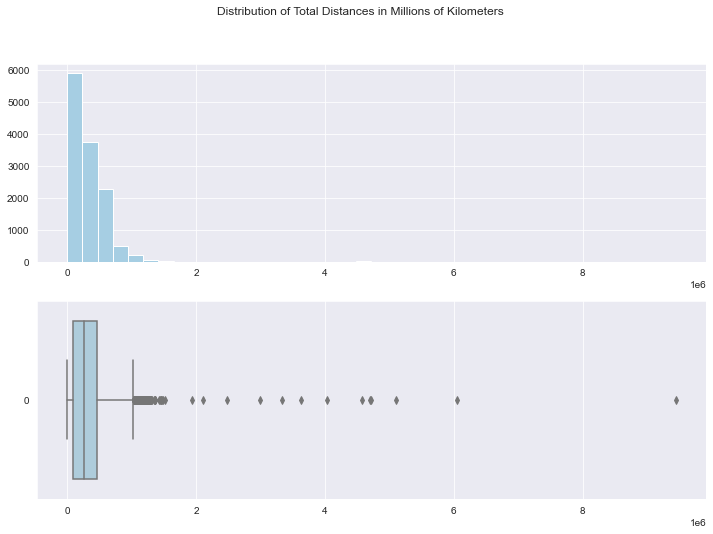

In [34]:
plt.suptitle('Distribution of Total Distances in Millions of Kilometers')
plt.subplot(2,1,1)
bus.total_kilometer.hist(figsize = (12,8), bins = 40)
plt.subplot(2,1,2)
sns.boxplot(data = bus.total_kilometer, orient='h')
plt.show() # this graph is in millions of kilometers

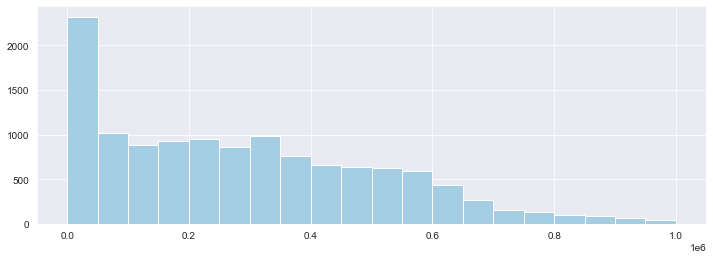

In [35]:
bus[bus['total_kilometer']<1000000].total_kilometer.hist(figsize = (12,4), bins = 20)
plt.show()

In [36]:
bus[bus['total_kilometer']>1900000]['total_kilometer'].value_counts()
# it's hard to say which actually drove that much and which might have accidentally 
# been written in meters rather than kilometers

5107024.0    1
1940317.0    1
4718582.0    1
4571971.0    1
9444510.0    1
6051050.0    1
4692296.0    1
3338776.0    1
3622114.0    1
2993886.0    1
4033302.0    1
2112202.0    1
2485900.0    1
Name: total_kilometer, dtype: int64

It's hard to say whether the busses actually drove that much or if they have accidentally been written in meters rather than kilometers.

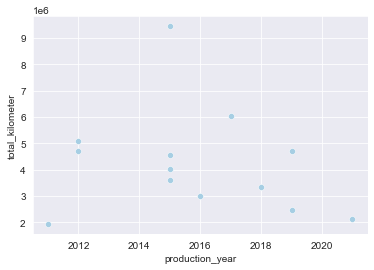

In [37]:
# bus[bus['total_kilometer']>1900000][['production_year', 'total_kilometer']].value_counts()
sns.scatterplot(data = bus[bus['total_kilometer']>1900000], x = 'production_year', 
                y = 'total_kilometer')
plt.show()
# suspicious but inconclusive

These exceptionally long-driving busses are all from the last decade, which strengthens the claim that they hadn't really driven exceptionally far, their total-kilometer values were simply written incorrectly.

I'd like to see whether the numbers of seats make sense: for that, I should consider how many busses are logged as having a particular seat-count, and the size of each bus.

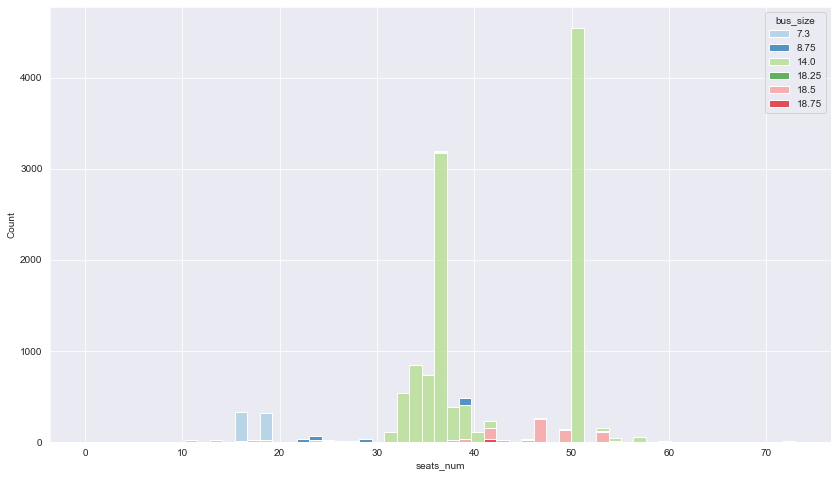

In [38]:

plt.figure(figsize = (14,8))
sns.histplot(data = bus, x = 'seats_num', multiple = 'stack', 
             palette = 'Paired',
             hue = 'bus_size', stat = 'count', element = 'bars', legend=True)

plt.show()

I consider the busses with over 10 seats to be reliable data even though less than 15 seats is very little seats for a bus, because those busses are around 7.3 meters long, and such busses often have few seats.

In [39]:
bus[bus['seats_num']<10]

operator  bus_license_id  is_stone_proof  is_bullet_proof  \
380    eged transport         8790201           False            False   
10576           kavim         1828811           False            False   

       bus_size  is_inter_city  seats_num  production_year production_country  \
380        14.0          False          0             2008        netherlands   
10576       7.3           True          2             2013            germany   

       total_kilometer parent_company  
380                NaN           eged  
10576              NaN          kavim

A bus with fewer than 3 seats is not a bus, it is a truck. I would say these are both typos, and since there are only 2 data-points with too few seats I believe it'd be best to remove these.

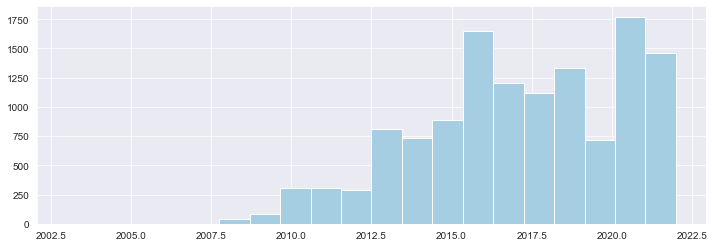

In [40]:
bus.production_year.hist(figsize = (12,4), bins = 20)
plt.show()

I consider busses from before 2007 to be outliers, but I don't intend to remove those, I want to analyse those as well.

I will replace all values for removal with null values and drop all rows that contain a null value. After removing those rows I will convert categorical fields to category datatype.

In [41]:
bus_clean = bus.copy()
bus_clean.loc[bus_clean['total_kilometer']>1900000,'total_kilometer'] = float('nan')
bus_clean.loc[bus_clean['total_kilometer']<=0,'total_kilometer'] = float('nan')
bus_clean.loc[bus_clean['seats_num']<3,'seats_num'] = float('nan') 
# a bus with two seats is not a bus, it's a truck
bus_clean.loc[bus_clean['production_country']=='unknown','production_country'] = float('nan')
bus_clean.loc[bus_clean['bus_license_id'].isin(duplicated_license),'bus_license_id'] = float('nan') 

bus_clean = bus_clean.dropna(axis = 0, how = 'any') 
bus_clean.parent_company = bus_clean.parent_company.astype('category')
bus_clean.operator = bus_clean.operator.astype('category')
bus_clean.production_country = bus_clean.production_country.astype('category')
bus.info()
bus_clean.info()
# about 5 percent lost

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12716 entries, 0 to 12715
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   operator            12716 non-null  object 
 1   bus_license_id      12716 non-null  int64  
 2   is_stone_proof      12716 non-null  bool   
 3   is_bullet_proof     12716 non-null  bool   
 4   bus_size            12716 non-null  float64
 5   is_inter_city       12716 non-null  bool   
 6   seats_num           12716 non-null  int64  
 7   production_year     12716 non-null  int64  
 8   production_country  12716 non-null  object 
 9   total_kilometer     12707 non-null  float64
 10  parent_company      12716 non-null  object 
dtypes: bool(3), float64(2), int64(3), object(3)
memory usage: 832.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12109 entries, 0 to 12715
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------           

The changes appear successful, and not too much data was lost - less than 5% of the original length.

### Data Enriching

In [42]:
bus_clean = bus_clean.drop('bus_license_id',axis = 1).reset_index(drop = True)
bus_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12109 entries, 0 to 12108
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   operator            12109 non-null  category
 1   is_stone_proof      12109 non-null  bool    
 2   is_bullet_proof     12109 non-null  bool    
 3   bus_size            12109 non-null  float64 
 4   is_inter_city       12109 non-null  bool    
 5   seats_num           12109 non-null  float64 
 6   production_year     12109 non-null  int64   
 7   production_country  12109 non-null  category
 8   total_kilometer     12109 non-null  float64 
 9   parent_company      12109 non-null  category
dtypes: bool(3), category(3), float64(3), int64(1)
memory usage: 451.8 KB


Adding a yearly average distance:

In [43]:
bus_clean['per_year'] = bus_clean['total_kilometer']/round(current.year - bus_clean.production_year)
bus_clean.loc[bus_clean['production_year']==current.year,'per_year'] = bus_clean['total_kilometer'] 
# to avoid infinity
bus_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12109 entries, 0 to 12108
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   operator            12109 non-null  category
 1   is_stone_proof      12109 non-null  bool    
 2   is_bullet_proof     12109 non-null  bool    
 3   bus_size            12109 non-null  float64 
 4   is_inter_city       12109 non-null  bool    
 5   seats_num           12109 non-null  float64 
 6   production_year     12109 non-null  int64   
 7   production_country  12109 non-null  category
 8   total_kilometer     12109 non-null  float64 
 9   parent_company      12109 non-null  category
 10  per_year            12109 non-null  float64 
dtypes: bool(3), category(3), float64(4), int64(1)
memory usage: 546.4 KB


Success.

### EDA
As well as graphing for the presentation.


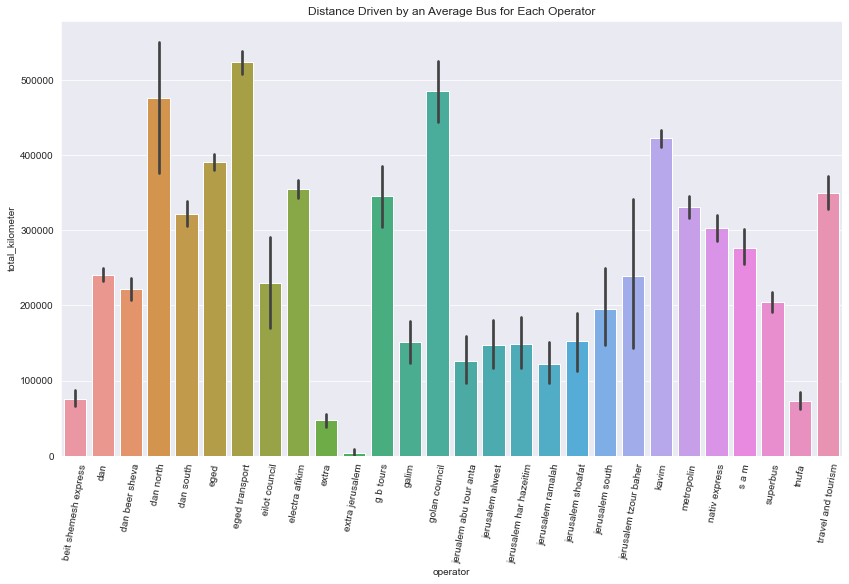

In [44]:
plt.figure(figsize=(14,8))
plt.xticks(rotation=80)
plt.title('Distance Driven by an Average Bus for Each Operator')
sns.barplot(data = bus_clean[['operator', 'total_kilometer']], x = 'operator', y = 'total_kilometer')
plt.show()

This answers a question I wonder about from time to time - "How much has a bus driven by the time i met it?"

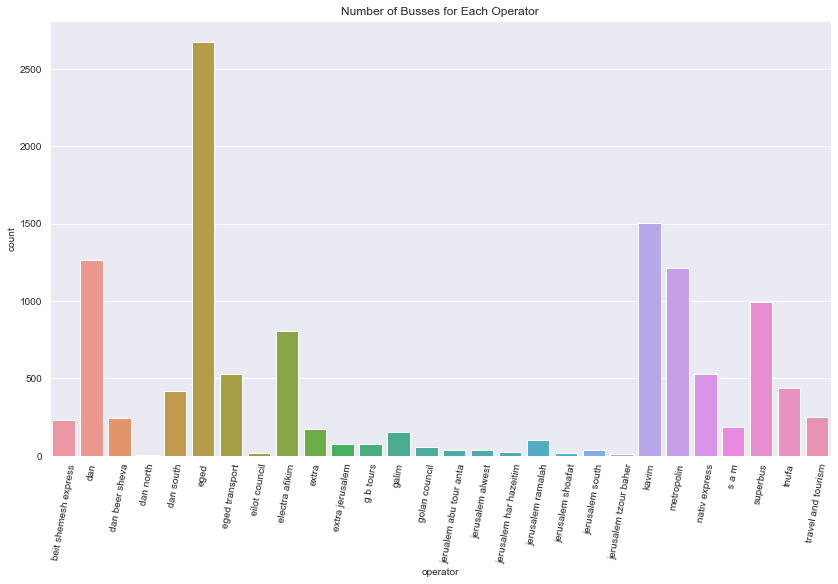

In [45]:
plt.figure(figsize=(14,8))
plt.xticks(rotation=80)
plt.title('Number of Busses for Each Operator')
sns.countplot(bus_clean['operator'])
plt.show()

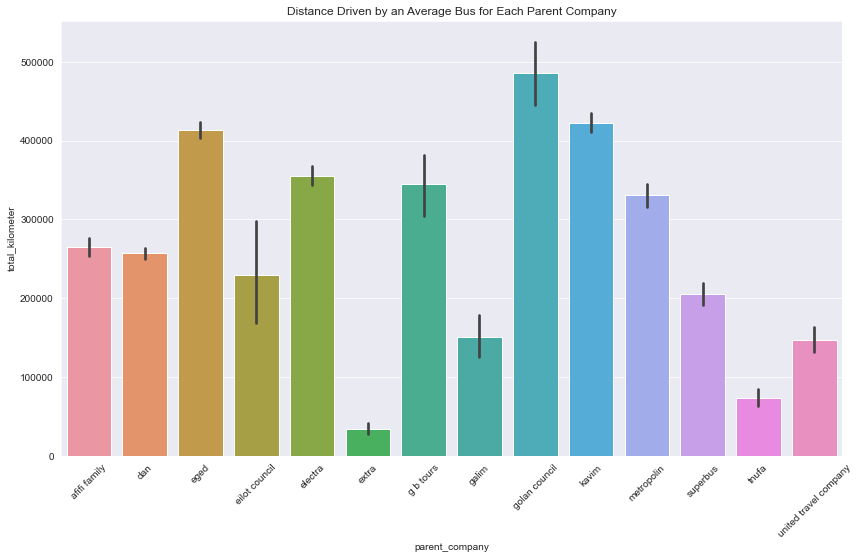

In [46]:
plt.figure(figsize=(14,8))
plt.xticks(rotation=45)
plt.title('Distance Driven by an Average Bus for Each Parent Company')
sns.barplot(data = bus_clean[['parent_company', 'total_kilometer']], x = 'parent_company', y = 'total_kilometer')
plt.show()

The "united travel company" is the bus company of all East-Jerusalem busses. As far as total distances go, Golan Council is above all others, followed by Kavim and Eged - which could mean they have to travel longer routes, or could mean that these companies keep using old busses rather than buying new ones even after a long distance was driven.

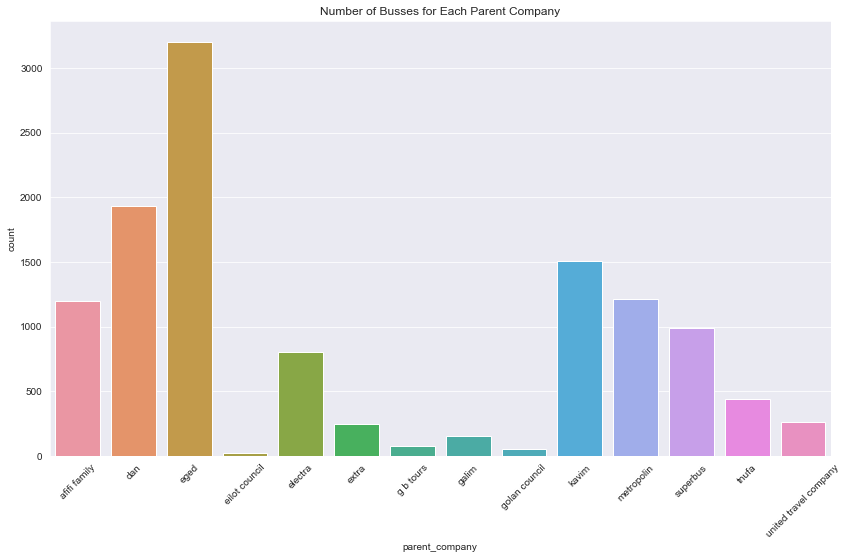

In [47]:
plt.figure(figsize=(14,8))
plt.xticks(rotation=45)
plt.title('Number of Busses for Each Parent Company')
sns.countplot(bus_clean['parent_company'])
plt.show()

The Afifi family are surprisingly influential for people I've never heard of until I made this project.

Viewing this data as numbers rather than a graph:

In [49]:
bus_count = bus_clean.groupby('parent_company')['bus_size'].count().reset_index(drop = False)
bus_count

parent_company  bus_size
0            afifi family      1197
1                     dan      1930
2                    eged      3203
3           eilot council        21
4                 electra       807
5                   extra       250
6               g b tours        78
7                   galim       153
8           golan council        56
9                   kavim      1506
10             metropolin      1210
11               superbus       992
12                  tnufa       441
13  united travel company       265

The Afifi family are following Metropolin very closely.

Pie chart to compare bus counts:

In [50]:
px.pie(bus_count, values='bus_size', names='parent_company', 
       title='Company Comparison in Terms of Total Busses')


In [51]:
bus_clean.operator.nunique(), bus_clean.parent_company.nunique()

(28, 14)

Pie chart to compare total distances:

In [52]:
px.pie(bus_clean, values='total_kilometer', names='parent_company', 
       title='Company Comparison in Terms of Total Distance')

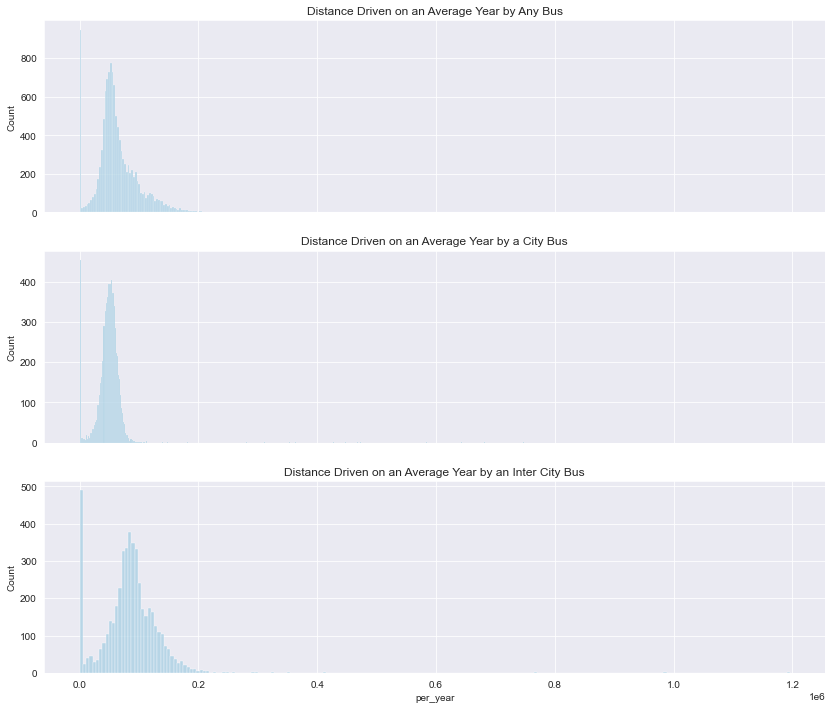

In [54]:

fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex = True, figsize = (14,12))

plt.subplot(311)
plt.title('Distance Driven on an Average Year by Any Bus')
ax1 = sns.histplot(data = bus_clean['per_year'])
plt.subplot(3,1,2)
plt.title('Distance Driven on an Average Year by a City Bus')
ax2 = sns.histplot(data = bus_clean[~bus_clean['is_inter_city']]['per_year'])
plt.subplot(3,1,3)
plt.title('Distance Driven on an Average Year by an Inter City Bus')
ax3 = sns.histplot(data = bus_clean[bus_clean['is_inter_city']]['per_year'])
plt.show()

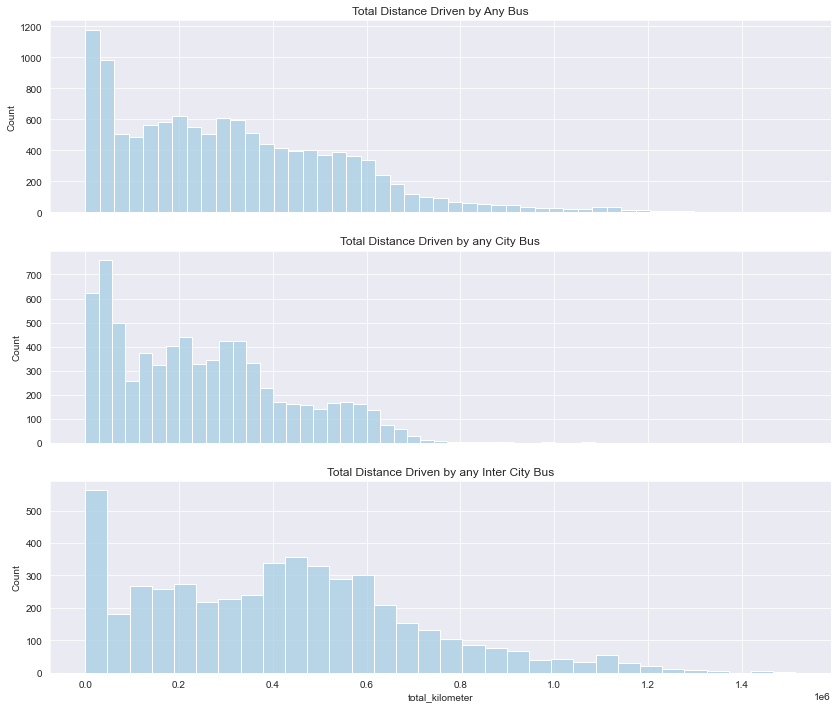

In [55]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex = True, figsize = (14,12))
plt.subplot(3,1,1)
plt.title('Total Distance Driven by Any Bus')
ax1 = sns.histplot(data = bus_clean['total_kilometer'])
plt.subplot(3,1,2)
plt.title('Total Distance Driven by any City Bus')
ax2 = sns.histplot(data = bus_clean[~bus_clean['is_inter_city']]['total_kilometer'])
plt.subplot(3,1,3)
plt.title('Total Distance Driven by any Inter City Bus')
ax3 = sns.histplot(data = bus_clean[bus_clean['is_inter_city']]['total_kilometer'])
plt.show()

In [56]:

print(bus_clean.loc[bus_clean.per_year.idxmin(),:], '\n',
      bus_clean.loc[bus_clean.per_year.idxmax(),:], '\n',
      bus_clean.loc[bus_clean.total_kilometer.idxmin(),:], '\n',
      bus_clean.loc[bus_clean.total_kilometer.idxmax(),:], '\n'
     )

operator                  eged
is_stone_proof           False
is_bullet_proof          False
bus_size                  14.0
is_inter_city             True
seats_num                 51.0
production_year           2019
production_country       china
total_kilometer            1.0
parent_company            eged
per_year              0.333333
Name: 1634, dtype: object 
 operator                    kavim
is_stone_proof              False
is_bullet_proof             False
bus_size                     14.0
is_inter_city                True
seats_num                    51.0
production_year              2021
production_country    switzerland
total_kilometer         1195556.0
parent_company              kavim
per_year                1195556.0
Name: 11365, dtype: object 
 operator                  eged
is_stone_proof           False
is_bullet_proof          False
bus_size                  14.0
is_inter_city             True
seats_num                 51.0
production_year           2019
production_

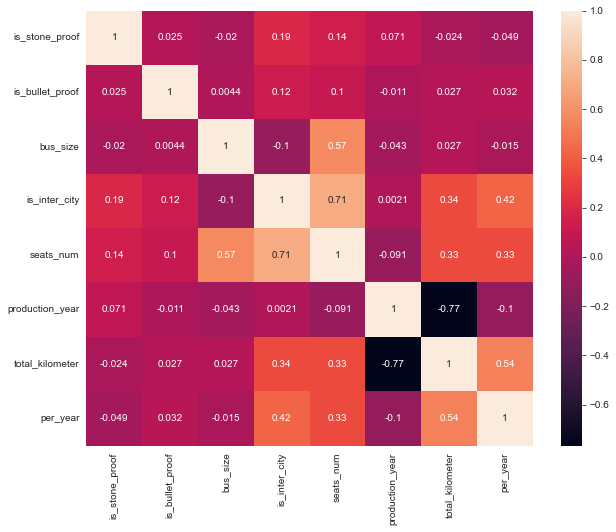

In [57]:
plt.figure(figsize = (10,8))
sns.heatmap(bus_clean.corr(), annot=True)
plt.show()

In [58]:
bus_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12109 entries, 0 to 12108
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   operator            12109 non-null  category
 1   is_stone_proof      12109 non-null  bool    
 2   is_bullet_proof     12109 non-null  bool    
 3   bus_size            12109 non-null  float64 
 4   is_inter_city       12109 non-null  bool    
 5   seats_num           12109 non-null  float64 
 6   production_year     12109 non-null  int64   
 7   production_country  12109 non-null  category
 8   total_kilometer     12109 non-null  float64 
 9   parent_company      12109 non-null  category
 10  per_year            12109 non-null  float64 
dtypes: bool(3), category(3), float64(4), int64(1)
memory usage: 546.4 KB


Graphs for the slide on busses wearing out over time:

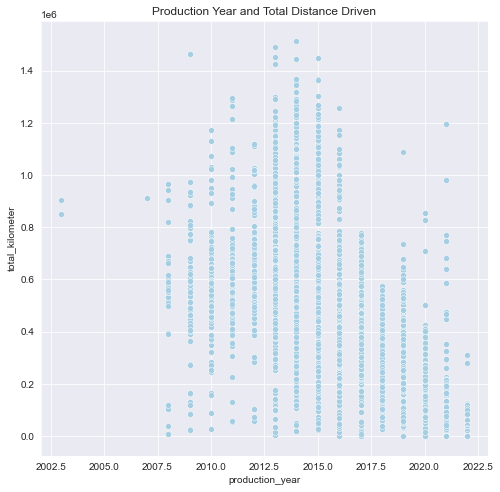

In [59]:
plt.figure(figsize=(8,8))
plt.title('Production Year and Total Distance Driven')
sns.scatterplot(data = bus_clean[['production_year', 'total_kilometer']], 
                x = 'production_year', y = 'total_kilometer')
plt.show()

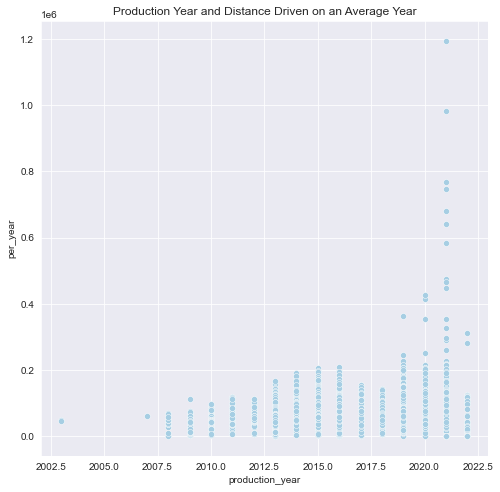

In [60]:
plt.figure(figsize=(8,8))
plt.title('Production Year and Distance Driven on an Average Year')
sns.scatterplot(data = bus_clean[['production_year', 'per_year']], 
                x = 'production_year', y = 'per_year')
plt.show()

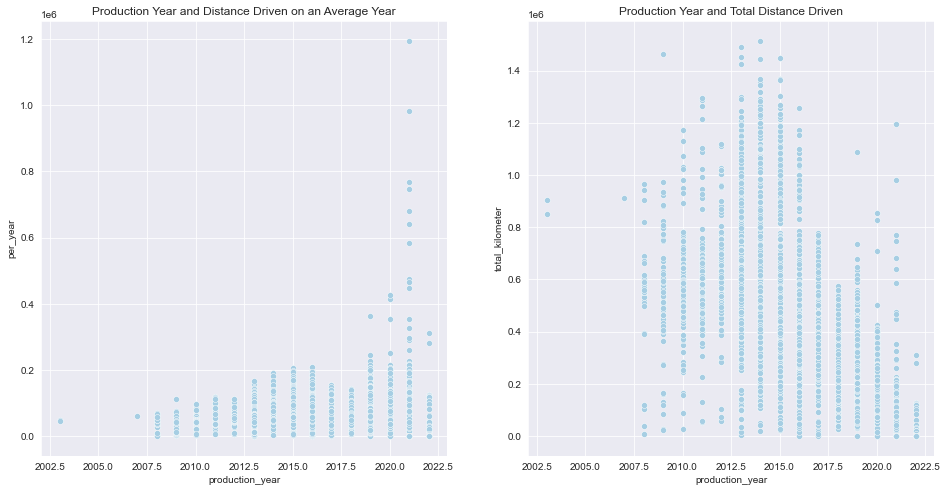

In [61]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.title('Production Year and Distance Driven on an Average Year')
sns.scatterplot(data = bus_clean[['production_year', 'per_year']], 
                x = 'production_year', y = 'per_year')
plt.subplot(122)
plt.title('Production Year and Total Distance Driven')
sns.scatterplot(data = bus_clean[['production_year', 'total_kilometer']], 
                x = 'production_year', y = 'total_kilometer')

plt.show()

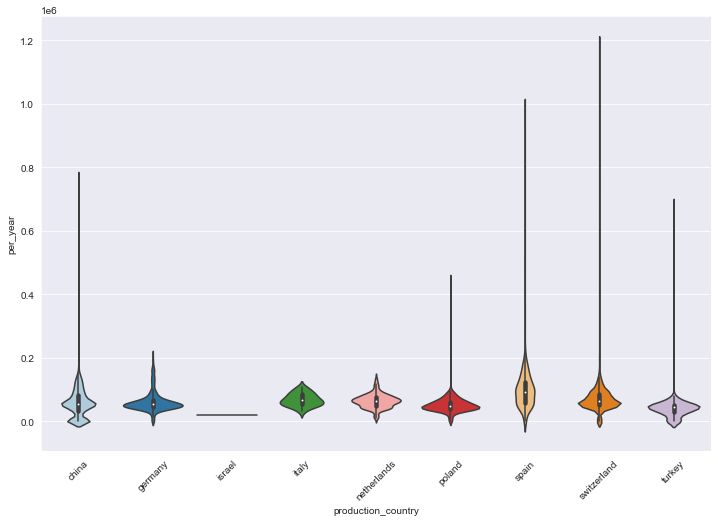

In [62]:
plt.figure(figsize = (12,8))
plt.xticks(rotation=45)
sns.violinplot(data = bus_clean, 
               x = 'production_country', y = 'per_year'#,
               #linewidth = 0.7
              ) # estimator is mean
plt.show()

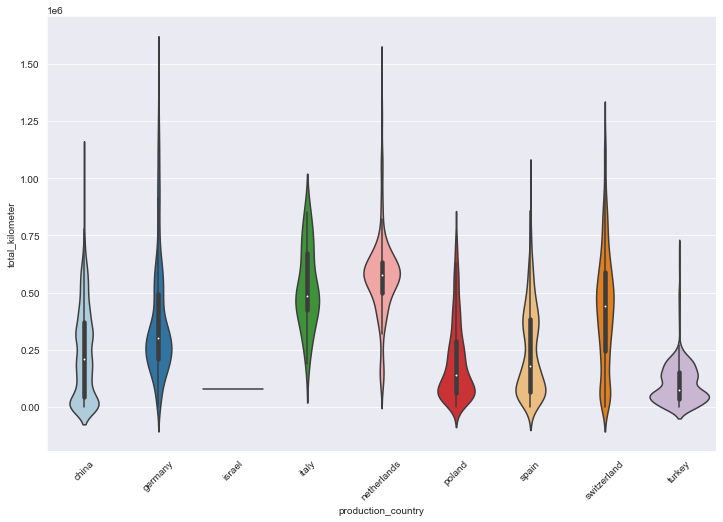

In [63]:
plt.figure(figsize = (12,8))
plt.xticks(rotation=45)
sns.violinplot(data = bus_clean, 
               x = 'production_country', y = 'total_kilometer'#,
               #linewidth = 0.7
              ) # estimator is mean
plt.show()

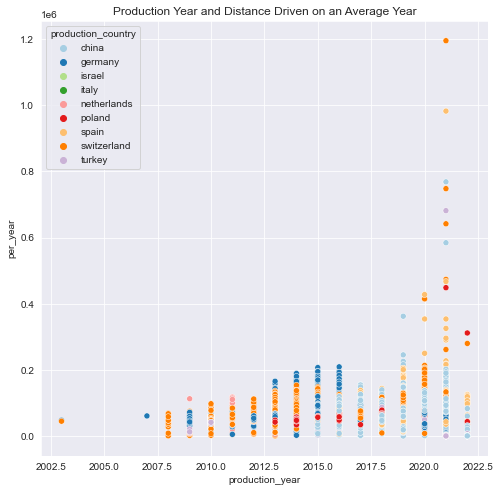

In [64]:
plt.figure(figsize=(8,8))
plt.title('Production Year and Distance Driven on an Average Year')
sns.scatterplot(data = bus_clean, 
                x = 'production_year', y = 'per_year', hue = 'production_country')
plt.show()

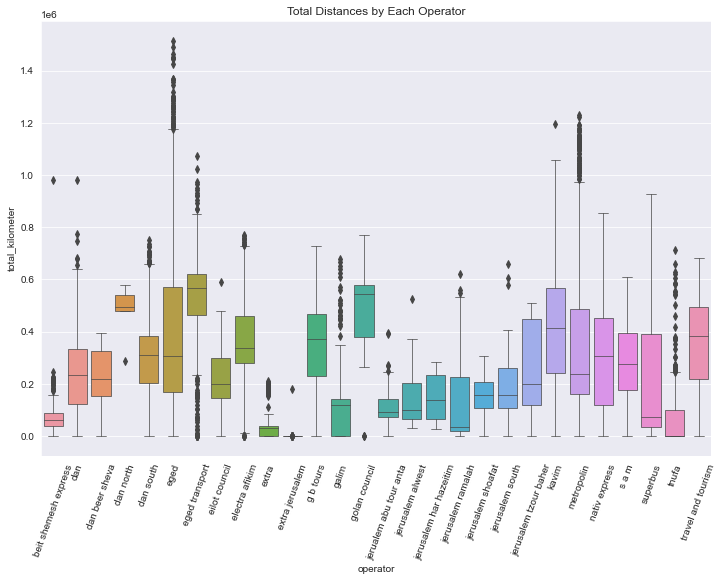

In [65]:
plt.figure(figsize = (12,8))
plt.xticks(rotation=70)
plt.title('Total Distances by Each Operator')
sns.boxplot(data = bus_clean, 
               x = 'operator', y = 'total_kilometer',
               linewidth = 0.7
              ) # estimator is mean
plt.show()

In [66]:
bus_clean.total_kilometer.median()

282442.0

In [67]:
bus_clean.per_year.median()

56110.0

In [68]:
bus_clean[bus_clean.total_kilometer==bus_clean.total_kilometer.median()]

operator  is_stone_proof  is_bullet_proof  bus_size  \
6710  jerusalem alwest           False            False      14.0   

      is_inter_city  seats_num  production_year production_country  \
6710           True       51.0             2015        switzerland   

      total_kilometer         parent_company      per_year  
6710         282442.0  united travel company  40348.857143

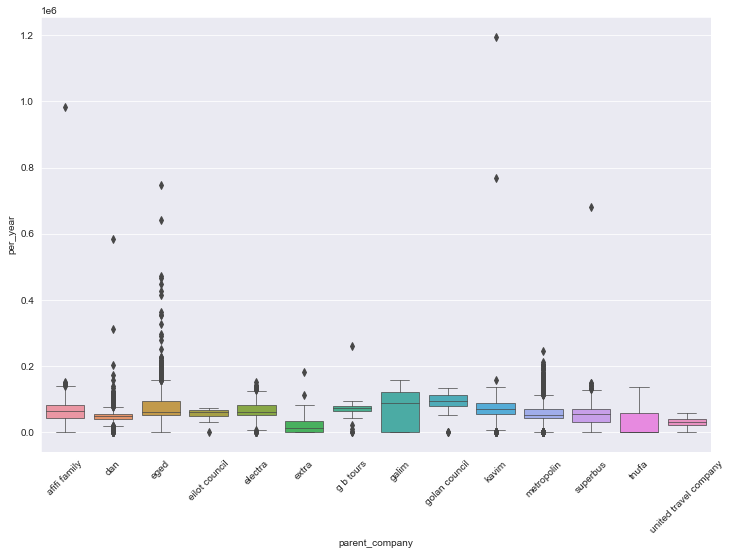

In [69]:
plt.figure(figsize = (12,8))
plt.xticks(rotation=45)
sns.boxplot(data = bus_clean, 
               x = 'parent_company', y = 'per_year',
               linewidth = 0.7
              ) # estimator is mean
plt.show()

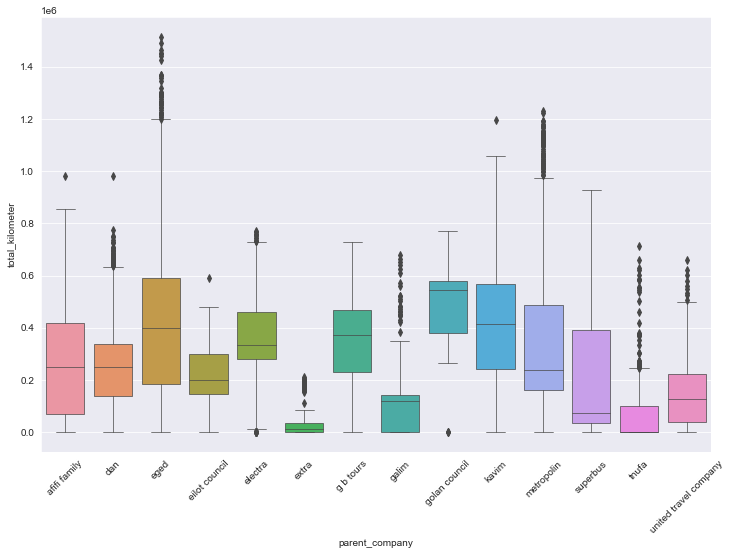

In [70]:
plt.figure(figsize = (12,8))
plt.xticks(rotation=45)
sns.boxplot(data = bus_clean, 
               x = 'parent_company', y = 'total_kilometer',
               linewidth = 0.7
              ) # estimator is mean
plt.show()

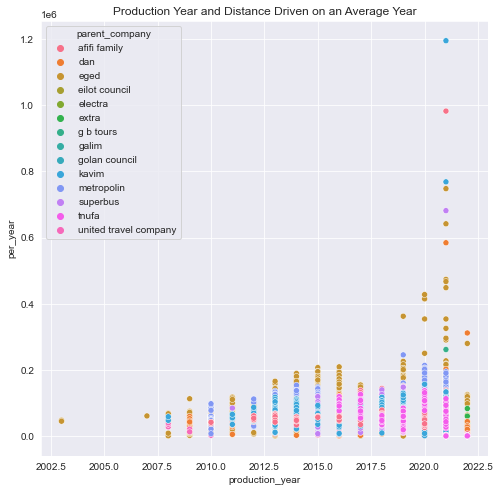

In [71]:
plt.figure(figsize=(8,8))
plt.title('Production Year and Distance Driven on an Average Year')
sns.scatterplot(data = bus_clean, 
                x = 'production_year', y = 'per_year', hue = 'parent_company')
plt.show()

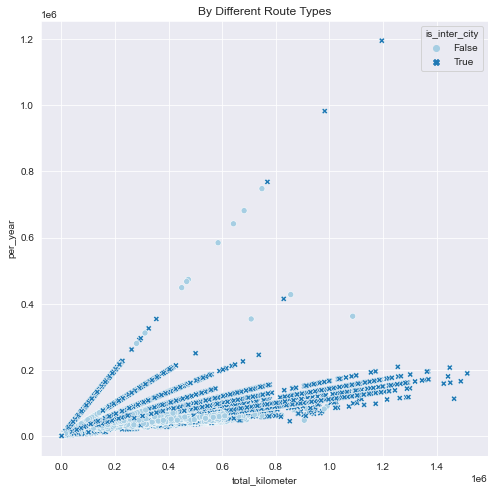

In [72]:
plt.figure(figsize = (8,8))
sns.scatterplot(data = bus_clean, 
                x = 'total_kilometer', y = 'per_year', hue = 'is_inter_city', style = 'is_inter_city')
plt.title('By Different Route Types')
plt.show()

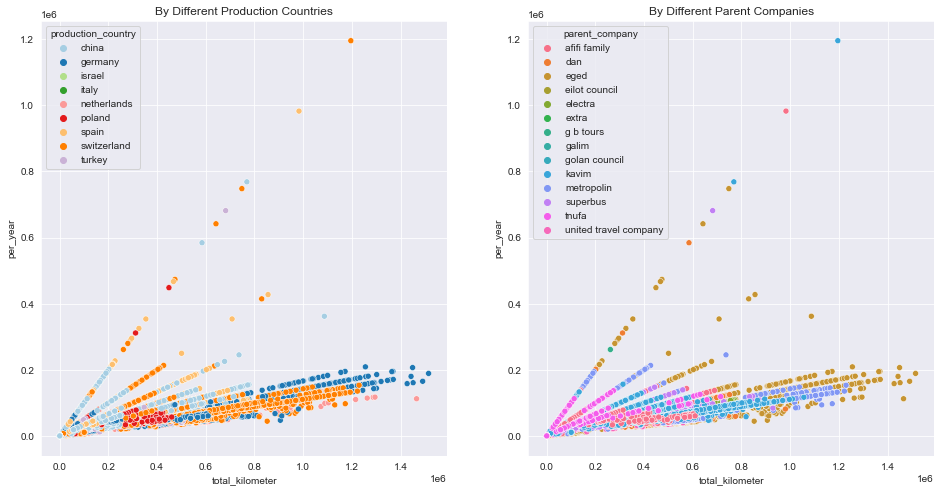

In [73]:
plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
sns.scatterplot(data = bus_clean, 
                x = 'total_kilometer', y = 'per_year', hue = 'production_country')
plt.title('By Different Production Countries')

plt.subplot(1,2,2)
sns.scatterplot(data = bus_clean, 
                x = 'total_kilometer', y = 'per_year', hue = 'parent_company'),
               #legend = False)
plt.title('By Different Parent Companies')
plt.show()


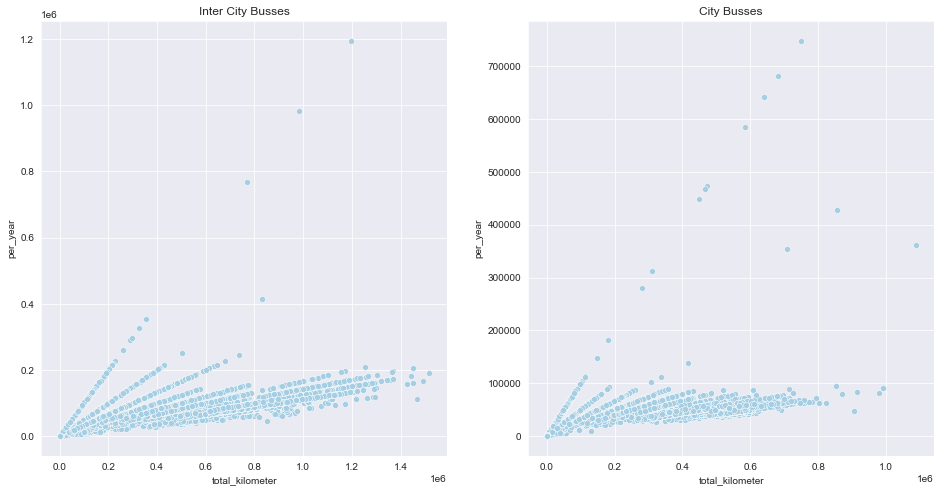

In [74]:
plt.figure(figsize = (16,8))
plt.subplot(1,2,1)
sns.scatterplot(data = bus_clean[bus_clean['is_inter_city']], 
                x = 'total_kilometer', y = 'per_year')
plt.title('Inter City Busses')

plt.subplot(1,2,2)
sns.scatterplot(data = bus_clean[~bus_clean['is_inter_city']], 
                x = 'total_kilometer', y = 'per_year')
plt.title('City Busses')
plt.show()


explanation vector for each year, dots far from center got through more distance

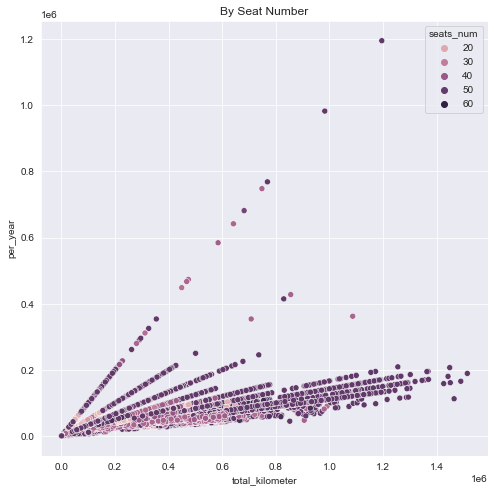

In [75]:
plt.figure(figsize=(8,8))
sns.scatterplot(data = bus_clean, 
                x = 'total_kilometer', y = 'per_year', hue = 'seats_num')
plt.title('By Seat Number')
plt.show()


In case the person reading this is Tal, then about what you said about time series, I had a slide in which I wanted to explain that we were looking at a partial time series - we're only seeing the buses that are still on the road. The following graph is for that slide.

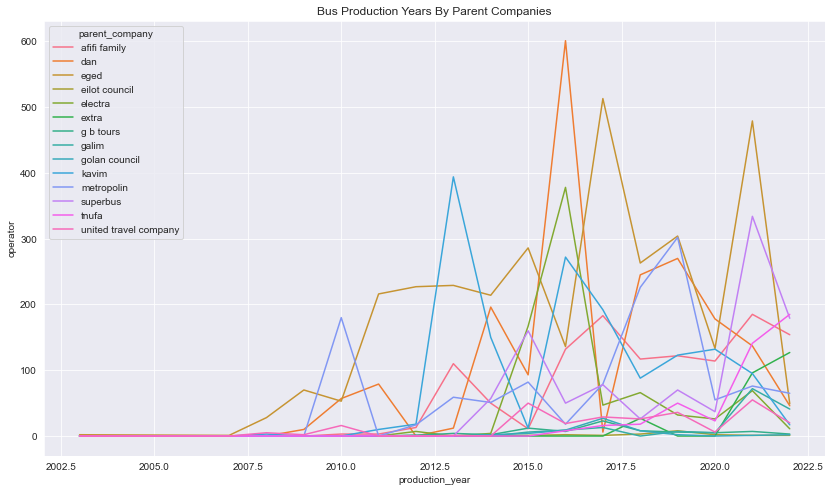

In [76]:
purchases = bus_clean.groupby(['production_year',
                               'parent_company'])['operator'].count().reset_index(drop = False)
distributers = bus_clean.groupby(['production_year',
                                  'production_country'])['operator'].count().reset_index(drop = False)

plt.figure(figsize = (14,8))
plt.title('Bus Production Years By Parent Companies')
sns.lineplot(data = purchases, x = 'production_year', y = 'operator', hue = 'parent_company')
plt.show()
#purchases.info()
#distributers.info()

In [77]:
bus_clean.production_year.min()

2003

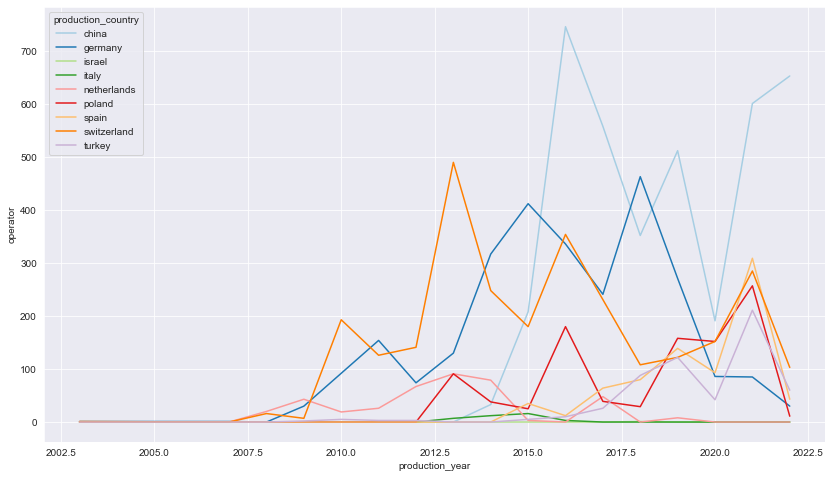

In [78]:
plt.figure(figsize = (14,8))
sns.lineplot(data = distributers, x = 'production_year', y = 'operator', hue = 'production_country')
plt.show()

### Preparing Data for Cluster Analysis
Using OHE for the fields I couldn't encode any other way, then scaling the data.

In [79]:
bus_ohe = pd.get_dummies(bus_clean, drop_first = False)
bus_ohe.head()

is_stone_proof  is_bullet_proof  bus_size  is_inter_city  seats_num  \
0           False            False      14.0           True       51.0   
1           False             True      14.0           True       51.0   
2           False             True      14.0           True       51.0   
3           False             True      14.0           True       51.0   
4           False             True      14.0           True       51.0   

   production_year  total_kilometer  per_year  operator_beit shemesh express  \
0             2010         948993.0  79082.75                              0   
1             2017         428194.0  85638.80                              0   
2             2017         352619.0  70523.80                              0   
3             2017         380961.0  76192.20                              0   
4             2017         431851.0  86370.20                              0   

   operator_dan  ...  parent_company_electra  parent_company_extra  \
0             0  ...                       0                     0   
1             0  ...                       0                     0   
2             0  ...                       0                     0   
3             0  ...                       0                     0   
4             0  ...                       0                     0   

   parent_company_g b tours  parent_company_galim  \
0                         0                     0   
1                         0                     0   
2                         0                     0   
3                         0                     0   
4                         0                     0   

   parent_company_golan council  parent_company_kavim  \
0                             0                     0   
1                             0                     0   
2                             0                     0   
3                             0                     0   
4                             0                     0   

   parent_company_metropolin  parent_company_superbus  parent_company_tnufa  \
0                          0                        0                     0   
1                          0                        0                     0   
2                          0                        0                     0   
3                          0                        0                     0   
4                          0                        0                     0   

   parent_company_united travel company  
0                                     0  
1                                     0  
2                                     0  
3                                     0  
4                                     0  

[5 rows x 59 columns]

In [80]:
gaussian = pd.DataFrame(data = PowerTransformer(method = 'yeo-johnson').fit_transform(bus_ohe),
                       columns = bus_ohe.columns,
                       index = bus_ohe.index)
minmax = pd.DataFrame(data = MinMaxScaler().fit_transform(bus_ohe),
                       columns = bus_ohe.columns,
                       index = bus_ohe.index)

display(gaussian.head())
display(minmax.head())

is_stone_proof  is_bullet_proof  bus_size  is_inter_city  seats_num  \
0       -0.180728        -0.114981 -0.005312       1.209206   1.093998   
1       -0.180728         8.697082 -0.005312       1.209206   1.093998   
2       -0.180728         8.697082 -0.005312       1.209206   1.093998   
3       -0.180728         8.697082 -0.005312       1.209206   1.093998   
4       -0.180728         8.697082 -0.005312       1.209206   1.093998   

   production_year  total_kilometer  per_year  operator_beit shemesh express  \
0        -2.085933         1.838752  0.529440                      -0.140069   
1        -0.091857         0.611958  0.672862                      -0.140069   
2        -0.091857         0.374645  0.334668                      -0.140069   
3        -0.091857         0.466598  0.464670                      -0.140069   
4        -0.091857         0.622842  0.688580                      -0.140069   

   operator_dan  ...  parent_company_electra  parent_company_extra  \
0     -0.341999  ...               -0.267214             -0.145193   
1     -0.341999  ...               -0.267214             -0.145193   
2     -0.341999  ...               -0.267214             -0.145193   
3     -0.341999  ...               -0.267214             -0.145193   
4     -0.341999  ...               -0.267214             -0.145193   

   parent_company_g b tours  parent_company_galim  \
0                 -0.080519             -0.113123   
1                 -0.080519             -0.113123   
2                 -0.080519             -0.113123   
3                 -0.080519             -0.113123   
4                 -0.080519             -0.113123   

   parent_company_golan council  parent_company_kavim  \
0                     -0.068163             -0.376876   
1                     -0.068163             -0.376876   
2                     -0.068163             -0.376876   
3                     -0.068163             -0.376876   
4                     -0.068163             -0.376876   

   parent_company_metropolin  parent_company_superbus  parent_company_tnufa  \
0                  -0.333196                -0.298718             -0.194411   
1                  -0.333196                -0.298718             -0.194411   
2                  -0.333196                -0.298718             -0.194411   
3                  -0.333196                -0.298718             -0.194411   
4                  -0.333196                -0.298718             -0.194411   

   parent_company_united travel company  
0                              -0.14958  
1                              -0.14958  
2                              -0.14958  
3                              -0.14958  
4                              -0.14958  

[5 rows x 59 columns]

is_stone_proof  is_bullet_proof  bus_size  is_inter_city  seats_num  \
0             0.0              0.0  0.585153            1.0        0.8   
1             0.0              1.0  0.585153            1.0        0.8   
2             0.0              1.0  0.585153            1.0        0.8   
3             0.0              1.0  0.585153            1.0        0.8   
4             0.0              1.0  0.585153            1.0        0.8   

   production_year  total_kilometer  per_year  operator_beit shemesh express  \
0         0.368421         0.626504  0.066147                            0.0   
1         0.736842         0.282684  0.071631                            0.0   
2         0.736842         0.232791  0.058988                            0.0   
3         0.736842         0.251501  0.063729                            0.0   
4         0.736842         0.285098  0.072242                            0.0   

   operator_dan  ...  parent_company_electra  parent_company_extra  \
0           0.0  ...                     0.0                   0.0   
1           0.0  ...                     0.0                   0.0   
2           0.0  ...                     0.0                   0.0   
3           0.0  ...                     0.0                   0.0   
4           0.0  ...                     0.0                   0.0   

   parent_company_g b tours  parent_company_galim  \
0                       0.0                   0.0   
1                       0.0                   0.0   
2                       0.0                   0.0   
3                       0.0                   0.0   
4                       0.0                   0.0   

   parent_company_golan council  parent_company_kavim  \
0                           0.0                   0.0   
1                           0.0                   0.0   
2                           0.0                   0.0   
3                           0.0                   0.0   
4                           0.0                   0.0   

   parent_company_metropolin  parent_company_superbus  parent_company_tnufa  \
0                        0.0                      0.0                   0.0   
1                        0.0                      0.0                   0.0   
2                        0.0                      0.0                   0.0   
3                        0.0                      0.0                   0.0   
4                        0.0                      0.0                   0.0   

   parent_company_united travel company  
0                                   0.0  
1                                   0.0  
2                                   0.0  
3                                   0.0  
4                                   0.0  

[5 rows x 59 columns]

Before selecting a scaling method, I want to view unscaled data, for comparison.

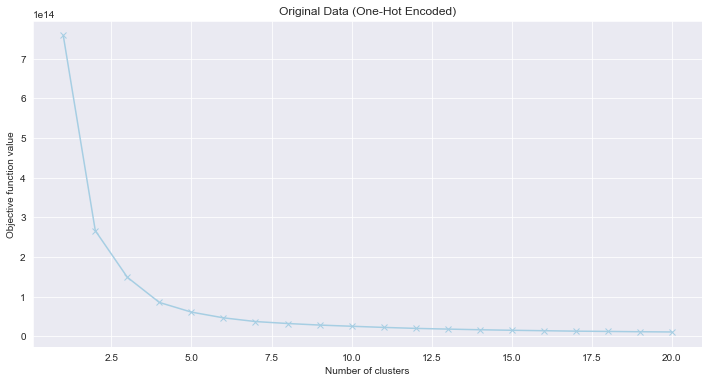

In [81]:
distortion = []
K = range(1, 21) # number of clusters from 1 to 20
for k in K:
    model = KMeans(n_clusters=k, 
               random_state=42) # for replicability
    model.fit(bus_ohe)
    distortion.append(model.inertia_)
plt.figure(figsize=(12, 6))
plt.plot(K, distortion, 'x-')
plt.xlabel('Number of clusters')
plt.ylabel('Objective function value')
plt.title('Original Data (One-Hot Encoded)')
plt.show()

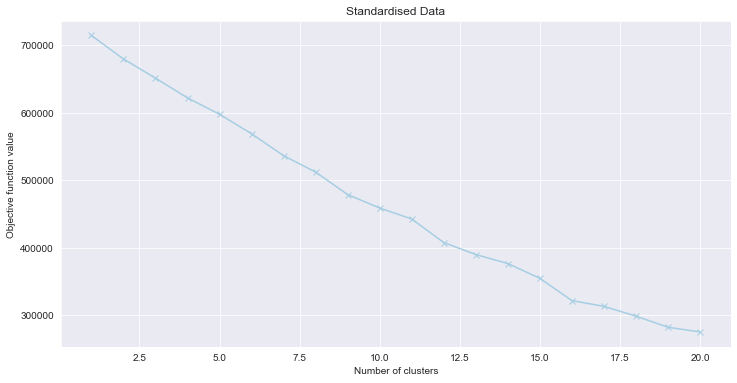

In [82]:
distortion = []
K = range(1, 21) # number of clusters from 1 to 20
for k in K:
    model = KMeans(n_clusters=k, 
               random_state=42) # for replicability
    model.fit(gaussian)
    distortion.append(model.inertia_)
plt.figure(figsize=(12, 6))
plt.plot(K, distortion, 'x-')
plt.xlabel('Number of clusters')
plt.ylabel('Objective function value')
plt.title('Standardised Data')
plt.show()

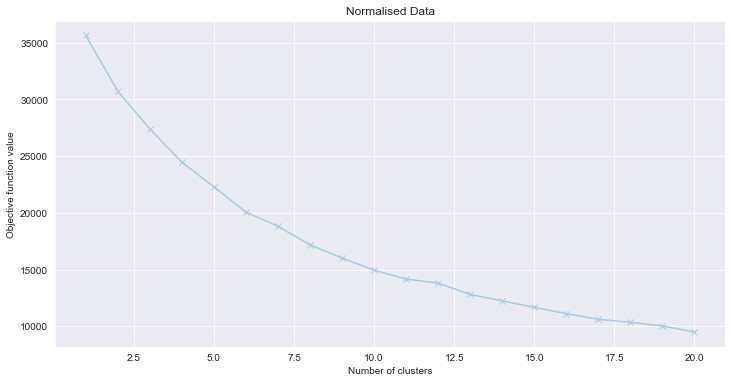

In [83]:
distortion = []
K = range(1, 21) # number of clusters from 1 to 20
for k in K:
    model = KMeans(n_clusters=k, 
               random_state=42) # for replicability
    model.fit(minmax)
    distortion.append(model.inertia_)
plt.figure(figsize=(12, 6))
plt.plot(K, distortion, 'x-')
plt.xlabel('Number of clusters')
plt.ylabel('Objective function value')
plt.title('Normalised Data')
plt.show()

decision 5 clusters and normalised data

In [84]:
bus_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12109 entries, 0 to 12108
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   operator            12109 non-null  category
 1   is_stone_proof      12109 non-null  bool    
 2   is_bullet_proof     12109 non-null  bool    
 3   bus_size            12109 non-null  float64 
 4   is_inter_city       12109 non-null  bool    
 5   seats_num           12109 non-null  float64 
 6   production_year     12109 non-null  int64   
 7   production_country  12109 non-null  category
 8   total_kilometer     12109 non-null  float64 
 9   parent_company      12109 non-null  category
 10  per_year            12109 non-null  float64 
dtypes: bool(3), category(3), float64(4), int64(1)
memory usage: 546.4 KB


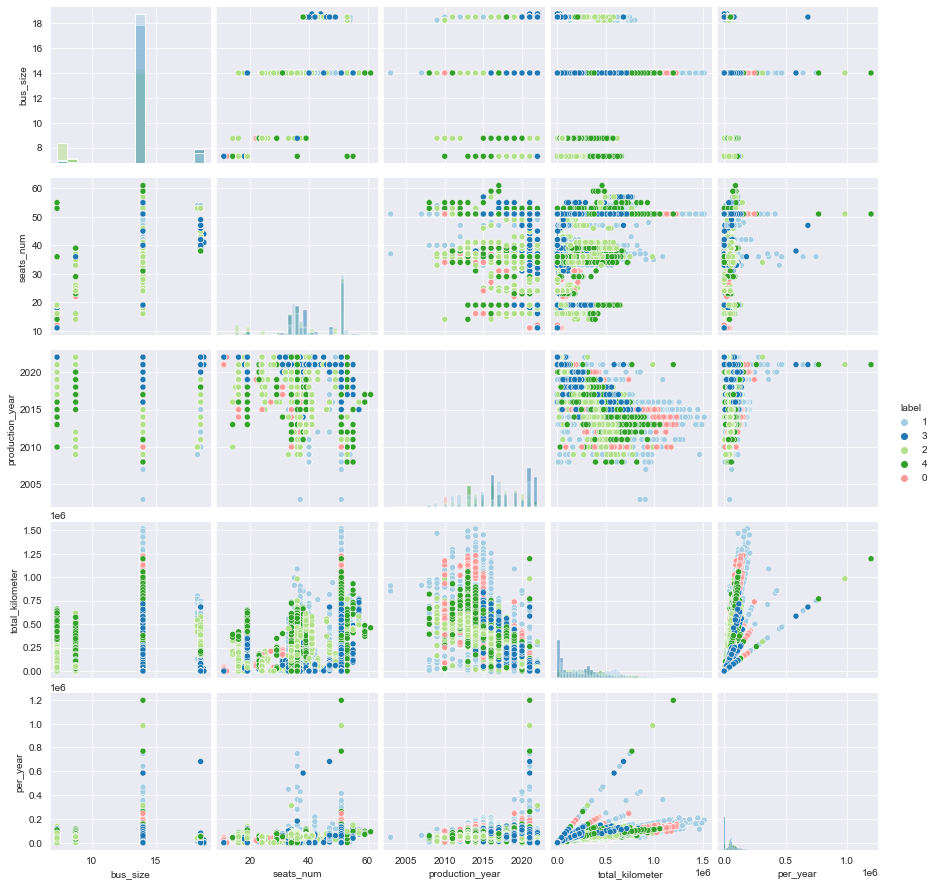

In [85]:
model = KMeans(n_clusters=5, 
               random_state=42) # for replicability
model.fit(minmax)
bus_clean['label'] = model.labels_.astype(str)
#centroids['label'] = ['0 centroid', '1 centroid', '2 centroid']

cols = ['bus_size', 'seats_num', 'production_year', 'total_kilometer', 'per_year', 'label']
pairgrid = sns.pairplot(bus_clean[cols], 
                        hue='label', 
                        diag_kind='hist')
plt.show()

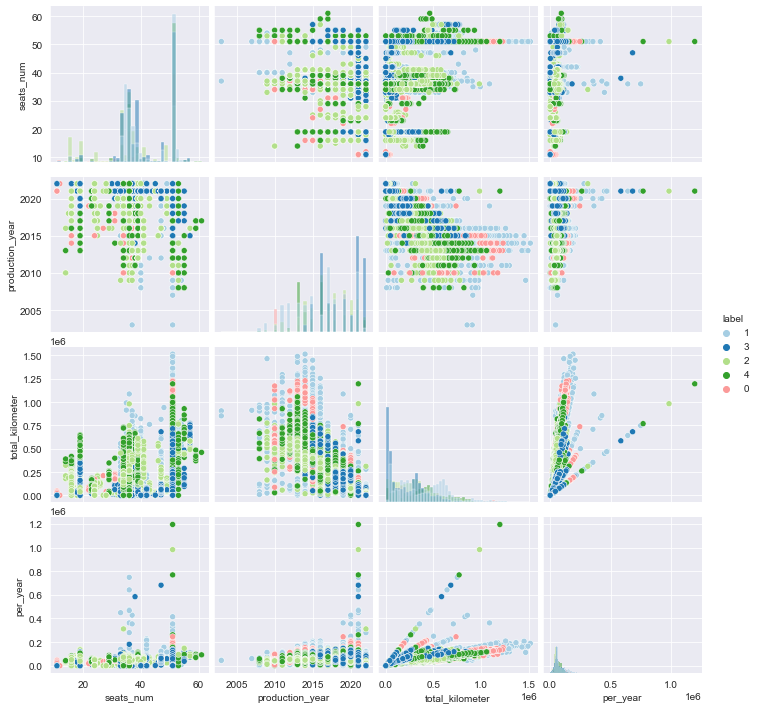

In [86]:
cols1 = ['seats_num', 'production_year', 'total_kilometer', 'per_year', 'label']
pairgrid = sns.pairplot(bus_clean[cols1], 
                        hue='label', 
                        diag_kind='hist')
plt.show()

In [87]:
bus_clean.label.unique()

array(['1', '3', '2', '4', '0'], dtype=object)

### Viewing each cluster seperately

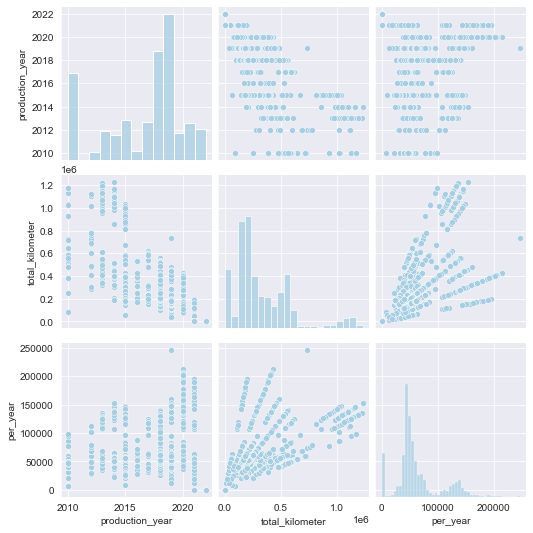

In [88]:
model = KMeans(n_clusters=5, 
               random_state=42) # for replicability
model.fit(minmax)
bus_clean['label'] = model.labels_.astype(str)
#centroids['label'] = ['0 centroid', '1 centroid', '2 centroid']


cols2 = ['production_year', 'total_kilometer', 'per_year', 'label']
#plt.figure(figsize=(12, 8))
pairgrid = sns.pairplot(bus_clean[bus_clean['label']=='0'][cols2], 
                        diag_kind='hist')
#pairgrid.figure.
plt.show()

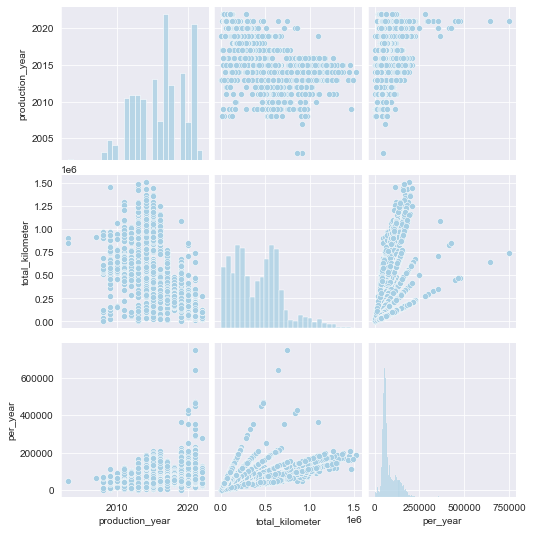

In [89]:
model = KMeans(n_clusters=5, 
               random_state=42) # for replicability
model.fit(minmax)
bus_clean['label'] = model.labels_.astype(str)
#centroids['label'] = ['0 centroid', '1 centroid', '2 centroid']


cols2 = ['production_year', 'total_kilometer', 'per_year', 'label']
#plt.figure(figsize=(12, 8))
pairgrid = sns.pairplot(bus_clean[bus_clean['label']=='1'][cols2], 
                        diag_kind='hist')
#pairgrid.figure.
plt.show()

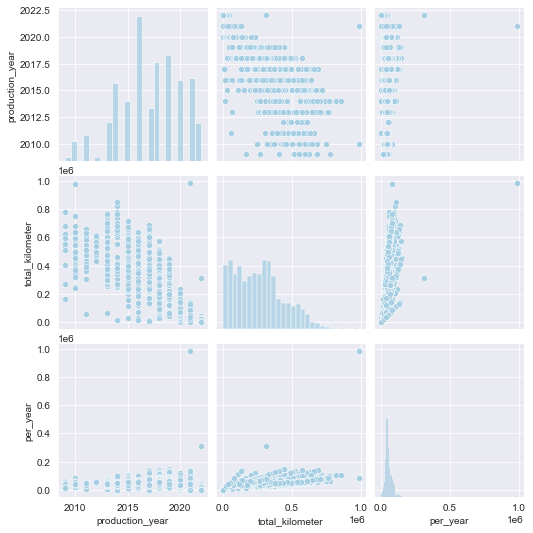

In [90]:
model = KMeans(n_clusters=5, 
               random_state=42) # for replicability
model.fit(minmax)
bus_clean['label'] = model.labels_.astype(str)
#centroids['label'] = ['0 centroid', '1 centroid', '2 centroid']


cols2 = ['production_year', 'total_kilometer', 'per_year', 'label']
#plt.figure(figsize=(12, 8))
pairgrid = sns.pairplot(bus_clean[bus_clean['label']=='2'][cols2], 
                        diag_kind='hist')
#pairgrid.figure.
plt.show()

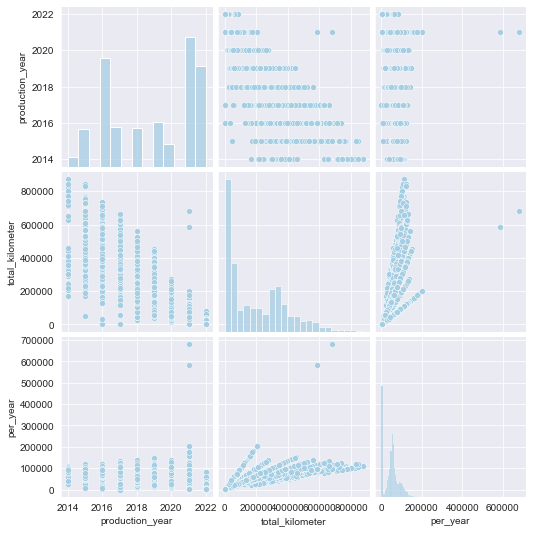

In [91]:
model = KMeans(n_clusters=5, 
               random_state=42) # for replicability
model.fit(minmax)
bus_clean['label'] = model.labels_.astype(str)
#centroids['label'] = ['0 centroid', '1 centroid', '2 centroid']


cols2 = ['production_year', 'total_kilometer', 'per_year', 'label']
#plt.figure(figsize=(12, 8))
pairgrid = sns.pairplot(bus_clean[bus_clean['label']=='3'][cols2], 
                        diag_kind='hist')
#pairgrid.figure.
plt.show()

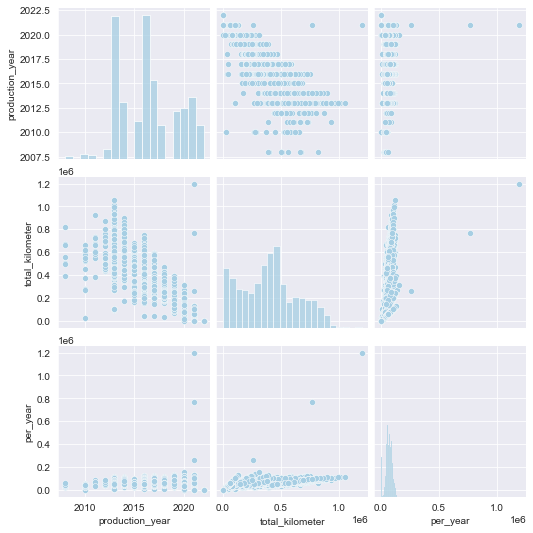

In [92]:
model = KMeans(n_clusters=5, 
               random_state=42) # for replicability
model.fit(minmax)
bus_clean['label'] = model.labels_.astype(str)
#centroids['label'] = ['0 centroid', '1 centroid', '2 centroid']


cols2 = ['production_year', 'total_kilometer', 'per_year', 'label']
#plt.figure(figsize=(12, 8))
pairgrid = sns.pairplot(bus_clean[bus_clean['label']=='4'][cols2], 
                        diag_kind='hist')
#pairgrid.figure.
plt.show()